# Neural networks with PyTorch

Deep learning networks 은 매우 많은 layer를 쌓아서 구성한다. 그래서 "deep"이라는 용어가 의미하는 바이기도 하다. PyTorch 에서는 `nn` module 을 사용하여 매우 커다란 neural network도 손쉽게 구현할 수 있는 기능을 제공한다.

In [2]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt


MNIST dataset은 손으로 씌여진 greyscale 숫자 이미지 데이터 이다. 각 이미지는 28x28 pixels 크기이다.
![img](../assets/mnist.png)


우리의 목표는 neural network 를 구성하여 손글씨 숫자를 인식하는/분류하는 모형을 생성하는 것이다.

맨 먼저 dataset을 다운로드하고 dataloder를 통해 읽어 들여야 한다. 이 데이터셋은 `torchvision` package를 통해 다운로드 가능하다. 아래 코드를 사용하여 training과 test datasets 을 다운로드 받을 수 있다. 여기서는 상세한 내용보다는 간단하게 모형을 구현하기 위한 기본적인 사항을 실습하도록 한다.

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('../data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

training data 를 `trainloader`로 읽어 들인다. 읽어들인 dataloader는 `iter(trainloader)` 명령어를 사용하여 iterator로 읽을 수 있다. iterator는 다음과 같은 for문을 통해 수행될 수 있다.

```python
for image, label in trainloader:
    ## do things with images and labels
```

`trainloader`의 batch size는 64이다. 이것은 한번에 읽을때 64개의 데이터를 읽어 들인다는 것이다. `shuffle=True`는 매번 data를 추출할 때 섞는다는 것이다.  따라서 `images`의 tensor size `(64, 1, 28, 28)`가 된다. 매 batch 마다 64 images 를 읽어 들이는데 각 1 color channel에 28x28 images이다.

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


읽어 들인 데이터 중 하나를 출력해 보자.

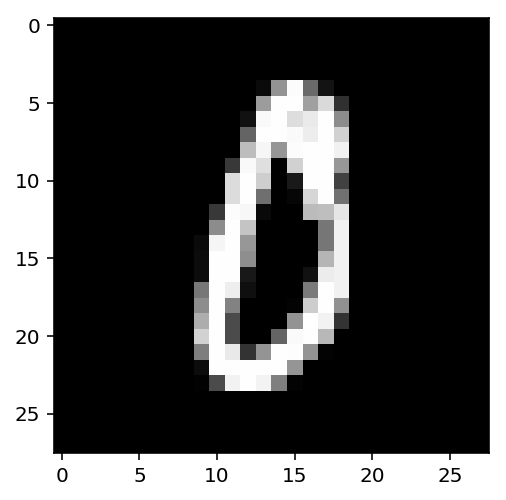

In [4]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

**weight matrices 와 matrix multiplications을 활용해 일단 simple network 를 구현해 보자.** 그리고 뒷쪽에서 PyTorch의 `nn` module 을 사용하여 network architectures를 구성해 보자.

이러한 networks를 *fully-connected* 또는 *dense* networks이라고 부른다. images 는 28x28 2D tensors이다.fully connected network은 1D vectors을 입력으로 받는다. 따라서 batch images의 shape `(64, 1, 28, 28)` 를  `(64, 784)`로 변경하여야 한다. 784 는 28 * 28 이다. 이것을 *flattening* 이라고 한다. 즉  2D images를 1D vectors 로 변환하는 과정이다.

이 모형에서는 10 output units을 사용한다.

0에서 9까지의 숫자로 총 출력값은 10개 이다.각 이미지를 처리하여 출력으로 해당 이미지가 어떤 클래스에 속하는지 분류하기 위해서 확률값을 출력한다. 즉 확률값이 이 이미지가 어떤 클래스에 속하는지 나타낸다. 

> **실습 :** batch 의 images `images`를 입력으로 처리하기 위해 flatten한다. 그리고 multi-layer network의 입력으로 784 input units, 256 hidden units, 그리고 10개 output units 으로 구성한다. weights 와 bias는 random값으로 초기화한다. sigmoid를 activation로 한다. output layer는 일단 activation를 적용하지 않는다. 뒤에서 softmax로 구현한다.

In [5]:
## Solution
def activation(x):
    return 1/(1+torch.exp(-x))

# Flatten the input images
inputs = images.view(images.shape[0], -1)

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = torch.mm(h, w2) + b2

최종 output layer의 활성화 함수는 [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function)를 사용한다. 수식으로 표현하면 다음과 같다.

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

이 소프트맥스 함수는 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수이다.  

분류하고 싶은 클래수의 수 만큼 출력으로 구성한다. 가장 큰 출력 값을 부여받은 클래스가 확률이 가장 높은 것으로 이용된다.

> **실습 :** `softmax` 함수를 구현한다. 연산시 shapes에 주의하도록 한다. 만약 tensor `a` 의 shape `(64, 10)` 이고 tensor `b`의 shape `(64,)`일 때 `a/b` 를 수행하면 error 난다. 왜냐면 size mismatch 때문이다. 따라서 `b` 의 shape 는 `(64, 1)`이 되어야 한다. `torch.sum` 에서 `dim` keyword 를 사용하는데 `dim=1` 을 사용하면  column끼리의 합을 계산한다.

In [6]:
## Solution
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building networks with PyTorch

PyTorch 는  `nn` 모듈을 제공하는데 이를 사용하면 networks를 매우 쉽게 구성할 수 있다.  784 inputs과 256 hidden units 그리고 10 output units 을 가지고 최종 layer의 활성화 함수는 softmax output로 구성해 보자.

In [7]:
from torch import nn

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

하나씩 살펴보자.

```python
class Network(nn.Module):
```

반드시 `nn.Module`을 상속하여야 한다. 필수적으로 `super().__init__()`로 부모의 생성자를 호출한다. 

```python
self.hidden = nn.Linear(784, 256)
```

위의 코드는 linear transformation을 수행하는데 수식으로 표현하면, $x\mathbf{W} + b$이다. 784 inputs 과 256 outputs 가 `self.hidden` layer에 할당된다. 이 module 은 자동으로 weight와 bias tensors를 초기화한다.  `net.hidden.weight` 와 `net.hidden.bias`로 확인할 수 있다.

```python
self.output = nn.Linear(256, 10)
```

유사하게 output layer는 256 inputs 과 10 outputs으로 구성한다.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

sigmoid activation 와 softmax output를 구성한다.`nn.Softmax(dim=1)`으로 columns에 대해서 계산한다.

```python
def forward(self, x):
```

반드시 필수적으로 `forward` method 를 구현해야 한다. tensor `x`를 받아서 `__init__` method로 forward pass를 진행한다.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

input tensor `x` 는 순서대로 forward pass를 통과한다.  

**input tensor-->hidden laye-->sigmoid function--> output layer-->softmax function**  
`__init__` method의 정의 순서와 상관없이  `forward` method의 순서대로 수행된다.

`Network` object를 생성한다.

In [9]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

보통은 `torch.nn.functional` module을 사용하여 forward pass를 구현한다.
`import torch.nn.functional as F`.

In [10]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

### Activation functions

가장 많이 사용되는 activation functions: Tanh (hyperbolic tangent), and ReLU (rectified linear unit).

![img](../assets/activation.png)

주로 **ReLU function** 이 hidden layers의 activation function으로 사용된다.

### Your Turn to Build a Network

![img](../assets/mlp_mnist.png)

> **실습 :**  784 input units-->128  hidden layer units -->ReLU activation-->hidden layer 64 units-->ReLU activation-->output layer --> softmax activation  
ReLU activation 은 `nn.ReLU` module 또는 `F.relu` function 로 구성한다.  
fully-connected layer의 이름은 `fc1`, `fc2`, `fc3` 로 한다.

In [11]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

자동으로 weights와 bias는 초기화 된다. `model.fc1.weight` 로 확인 가능하다.

In [12]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0052,  0.0303, -0.0210,  ..., -0.0122,  0.0289,  0.0340],
        [ 0.0155,  0.0297,  0.0187,  ..., -0.0227, -0.0207,  0.0008],
        [ 0.0128,  0.0224, -0.0244,  ..., -0.0341, -0.0233,  0.0140],
        ...,
        [-0.0200, -0.0278,  0.0108,  ...,  0.0145, -0.0243, -0.0109],
        [-0.0075,  0.0328,  0.0285,  ...,  0.0009, -0.0075, -0.0056],
        [ 0.0183, -0.0162,  0.0205,  ...,  0.0162,  0.0004,  0.0317]],
       requires_grad=True)
Parameter containing:
tensor([ 4.4727e-03,  1.0690e-02, -2.0325e-02,  1.1917e-02,  3.3781e-02,
        -3.3077e-02, -3.2304e-02,  7.9966e-03,  3.3438e-02, -1.0184e-02,
         2.3305e-02, -3.4010e-02, -1.0595e-02,  2.2180e-02,  1.5894e-02,
         5.5169e-03,  1.5546e-03,  3.0683e-03, -3.2810e-02, -2.9899e-02,
         8.9667e-03,  3.5057e-02,  3.3338e-02,  2.7075e-02,  7.1798e-05,
        -6.5174e-03, -6.7059e-04,  2.0659e-02,  6.2314e-03,  3.5303e-02,
         5.0284e-03,  1.2763e-02, -3.4676e-02,  3.2629e-0

### Forward pass

forward pass를 적용하여 결과를 확인해 보자.

In [13]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

결과를 시각화하기 위한 보조 함수를 만들어 보자.

In [14]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    
    ax2.set_yticklabels(np.arange(10))
    
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

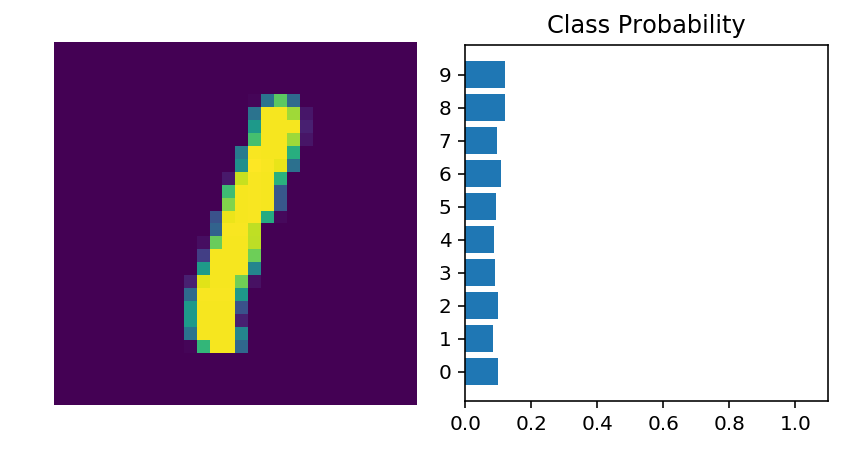

In [15]:
img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

당연하게도 결과가 제대로 나오지 않는다! 모형의 훈련이 되지 않았기 때문이다.

### Using `nn.Sequential`

PyTorch는 networks 손쉽게 구현하기 위해 `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential))을 제공한다.

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


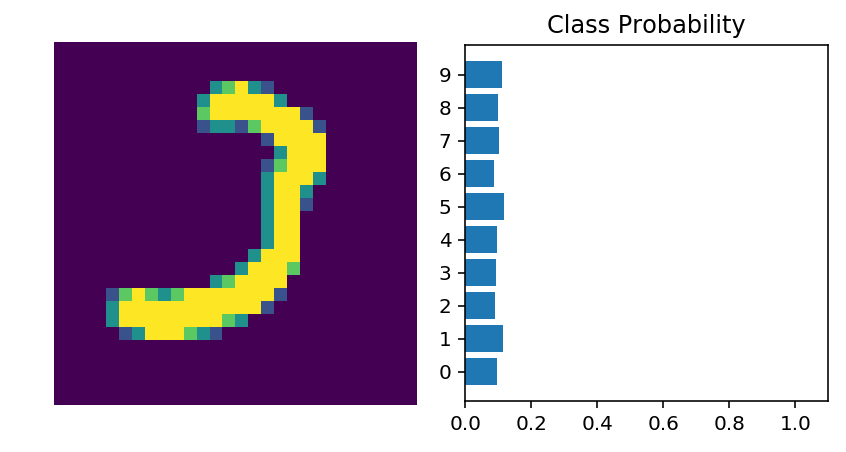

In [16]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

모형의 각 layer는 `model[0]` 처럼 번호로 access 된다.

In [17]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 3.1888e-02,  2.6864e-02,  3.0777e-02,  ...,  3.1750e-02,
         -1.2100e-02,  8.6352e-03],
        [ 3.0711e-02, -1.5782e-02,  2.2466e-02,  ..., -8.0776e-03,
         -2.7429e-02,  2.6015e-02],
        [-1.5187e-02, -1.7152e-02,  2.5806e-03,  ...,  2.7342e-02,
         -9.5251e-03, -3.0681e-02],
        ...,
        [ 1.0043e-02, -1.2134e-02, -1.6364e-02,  ...,  2.6784e-03,
          1.7243e-04, -8.2027e-05],
        [-3.3883e-02,  5.9809e-03,  2.7744e-02,  ...,  3.2830e-02,
          9.0345e-03, -7.8368e-04],
        [ 2.7284e-02,  2.1706e-02,  2.7469e-02,  ..., -3.3144e-02,
         -2.6391e-02, -1.4769e-02]], requires_grad=True)